<a href="https://colab.research.google.com/github/zjzsu2000/CMPE258/blob/master/assignment2/1)mnist_classifier_with_autodiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0-rc3


##Part I) Do write autodiff python  library and based on it , do  mnist classifier

###AutoDiffTensor

In [0]:
import numpy as np

class AutoDiffTensor (object):
    
    def __init__(self,dataInput,autodiff=False,creators=None,creationOperation=None,randID=None):
        
        self.data = np.array(dataInput)
        self.autodiff = autodiff
        self.grad = None
        if(randID is None):
            self.randID = np.random.randint(0,10000)
        else:
            self.randID = randID
        
        self.creators = creators
        self.creationOperation = creationOperation
        self.children = {}
        if(creators is not None):
            for creator in creators:
                if(self.randID not in creator.children):
                    creator.children[self.randID] = 1
                else:
                    creator.children[self.randID] += 1

    def counted(self):
        for randID,count in self.children.items():
            if(count  != 0):
                return False
        return True 
        
    def backWard(self,grad=None, grad_origin=None):
        if(self.autodiff==True):
 
            if(grad is None):
                grad = AutoDiffTensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.randID] == 0):
                    raise Exception("can't backprop more than once")
                else:
                    self.children[grad_origin.randID] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have their own grads
            assert grad.autodiff == False
            
            
            if(self.creators is not None and (self.counted() or grad_origin is None)):

                # adding function
                if(self.creationOperation == "add"):
                    self.creators[0].backWard(self.grad, self)
                    self.creators[1].backWard(self.grad, self)
                    
                #  subtracting function
                if(self.creationOperation == "sub"):
                    self.creators[0].backWard(AutoDiffTensor(self.grad.data), self)
                    self.creators[1].backWard(AutoDiffTensor(self.grad.__neg__().data), self)

                # multiply function
                if(self.creationOperation == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backWard(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backWard(new, self)                    
                    
                # matrix multiplication function
                if(self.creationOperation == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mM(c1.transpose())
                    c0.backWard(new)
                    new = self.grad.transpose().mM(c0).transpose()
                    c1.backWard(new)
                    
                # transpose 
                if(self.creationOperation == "transpose"):
                    self.creators[0].backWard(self.grad.transpose())

                if("sum" in self.creationOperation):
                    dim = int(self.creationOperation.split("_")[1])
                    self.creators[0].backWard(self.grad.expand(dim,self.creators[0].data.shape[dim]))

                if("expand" in self.creationOperation):
                    dim = int(self.creationOperation.split("_")[1])
                    self.creators[0].backWard(self.grad.sum(dim))
                    
                if(self.creationOperation == "neg"):
                    self.creators[0].backWard(self.grad.__neg__())
                    
                if(self.creationOperation == "sigmoid"):
                    ones = AutoDiffTensor(np.ones_like(self.grad.data))
                    self.creators[0].backWard(self.grad * (self * (ones - self)))

                if(self.creationOperation == "relu"):
                    ones = AutoDiffTensor(np.ones_like(self.grad.data))
                    self.creators[0].backWard(self.grad * (ones - (self * self)))
                
                if(self.creationOperation == "tanh"):
                    ones = AutoDiffTensor(np.ones_like(self.grad.data))
                    self.creators[0].backWard(self.grad * (ones - (self * self)))

                if(self.creationOperation == "cross_entropy"):
                    # print("Softmax Output", self.softmax_output)
                    # print("Target", self.target_dist)
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backWard(AutoDiffTensor(dx))
                
                if(self.creationOperation == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backWard(AutoDiffTensor(new_grad))

                    
    def __add__(self, other):
        if(self.autodiff and other.autodiff):
            return AutoDiffTensor(self.data + other.data,
                          autodiff=True,
                          creators=[self,other],
                          creationOperation="add")
        return AutoDiffTensor(self.data + other.data)

    def __neg__(self):
        if(self.autodiff):
            return AutoDiffTensor(self.data * -1,
                          autodiff=True,
                          creators=[self],
                          creationOperation="neg")
        return AutoDiffTensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autodiff and other.autodiff):
            return AutoDiffTensor(self.data - other.data,
                          autodiff=True,
                          creators=[self,other],
                          creationOperation="sub")
        return AutoDiffTensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autodiff and other.autodiff):
            return AutoDiffTensor(self.data * other.data,
                          autodiff=True,
                          creators=[self,other],
                          creationOperation="mul")
        return AutoDiffTensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autodiff):
            return AutoDiffTensor(self.data.sum(dim),
                          autodiff=True,
                          creators=[self],
                          creationOperation="sum_"+str(dim))
        return AutoDiffTensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autodiff):
            return AutoDiffTensor(new_data,
                          autodiff=True,
                          creators=[self],
                          creationOperation="expand_"+str(dim))
        return AutoDiffTensor(new_data)
    
    def transpose(self):
        if(self.autodiff):
            return AutoDiffTensor(self.data.transpose(),
                          autodiff=True,
                          creators=[self],
                          creationOperation="transpose")
        
        return AutoDiffTensor(self.data.transpose())
    
    def mM(self, x):
        if(self.autodiff):
            return AutoDiffTensor(self.data.dot(x.data),
                          autodiff=True,
                          creators=[self,x],
                          creationOperation="mm")
        return AutoDiffTensor(self.data.dot(x.data))
    
    #Sigmoid
    def sigmoid(self):
        if(self.autodiff):
            return AutoDiffTensor(1 / (1 + np.exp(-self.data)),
                          autodiff=True,
                          creators=[self],
                          creationOperation="sigmoid")
        return AutoDiffTensor(1 / (1 + np.exp(-self.data)))

    #Tanh
    def tanh(self):
        if(self.autodiff):
            return AutoDiffTensor(np.tanh(self.data),
                          autodiff=True,
                          creators=[self],
                          creationOperation="tanh")
        return AutoDiffTensor(np.tanh(self.data))

    #Rulu
    def relu(self):
        if(self.autodiff):
            return AutoDiffTensor(((self.data > 0) * self.data),
                          autodiff=True,
                          creators=[self],
                          creationOperation="relu")
        return AutoDiffTensor(np.tanh(self.data))
    
    #SelectIndex
    def selectIndex(self, indices):

        if(self.autodiff):
            new = AutoDiffTensor(self.data[indices.data],
                         autodiff=True,
                         creators=[self],
                         creationOperation="index_select")
            new.selectIndex = indices
            return new
        return AutoDiffTensor(self.data[indices.data])
    
    #CrossEntropy
    def crossEntropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        # print("P:", p)
        # print("T:", t)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autodiff):
            out = AutoDiffTensor(loss,autodiff=True,
                         creators=[self],creationOperation="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out
        return AutoDiffTensor(loss)
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):        
        return str(self.data.__str__())  


### Add Layer and subClasses

####Layer Class

In [0]:
class Layer(object):    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters




####Tanh,Sigmoid,RELU,SoftMax

In [0]:
class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forWard(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forWard(self, input):
        return input.sigmoid()

class Relu(Layer):
    def __init__(self):
        super().__init__()
    
    def forWard(self, input):
        return input.relu()
    

class Softmax(Layer):
    def __init__(self):
        super().__init__()
    
    def forWard(self, input):
        return input.softmax()

####Linear Layer

In [0]:

class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = AutoDiffTensor(W, autodiff=True)
        self.bias = AutoDiffTensor(np.zeros(n_outputs), autodiff=True)
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forWard(self, input):
        return input.mM(self.weight)+self.bias.expand(0,len(input.data))

#### Sequential Layer

In [0]:

class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forWard(self, input):
        for layer in self.layers:
            input = layer.forWard(input)
        return input
    
    def get_parameters(self):
        parameters = list()
        for layer in self.layers:
            parameters += layer.get_parameters()
        return parameters



####Embedding Layer

In [0]:
class Embedding(Layer):
    
    def __init__(self, vocab_size, dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.dim = dim
        
        # this random initialiation style is just a convention from word2vec
        self.weight = AutoDiffTensor((np.random.rand(vocab_size, dim) - 0.5) / dim)
        
        self.parameters.append(self.weight)
    
    def forWard(self, input):
        return self.weight.selectIndex(input)

####Loss

In [0]:
class MSELoss(Layer):
    def __init__(self):
        super().__init__()
    
    def forWard(self, pred, target):
        return ((pred - target)*(pred - target)).sum(0)

###SGD Optimization

In [0]:
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for parameter in self.parameters:
            parameter.grad.data *= 0
        
    def step(self, zero=True):
        
        for parameter in self.parameters:
            
            parameter.data -= parameter.grad.data * self.alpha
            
            if(zero):
                parameter.grad.data *= 0


##Do mnist classifier

#### Import the dataset:MNIST database of handwritten digits

Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

https://keras.io/datasets/#mnist-database-of-handwritten-digits

In [0]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [0]:
np.int8(test_labels)

array([7, 2, 1, ..., 4, 5, 6], dtype=int8)

In [0]:
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

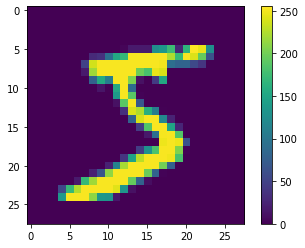

In [0]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. 

In [0]:
np.random.seed(1)

In [0]:
images, labels = (train_images[0:2000].reshape(2000,28*28) / 255), train_labels[0:2000]

In [0]:
one_hot_labels = np.zeros((len(labels), 10))

In [0]:
for i,l in enumerate(labels):
  one_hot_labels[i][l] = 1
labels = one_hot_labels

test_img = test_images.reshape(len(test_images), 28*28) / 255
test_label = np.zeros((len(test_labels), 10))

for i,l in enumerate(test_labels):
    test_label[i][l] = 1

In [0]:
images.shape

(2000, 784)

In [0]:
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

To verify that the data is in the correct format and ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

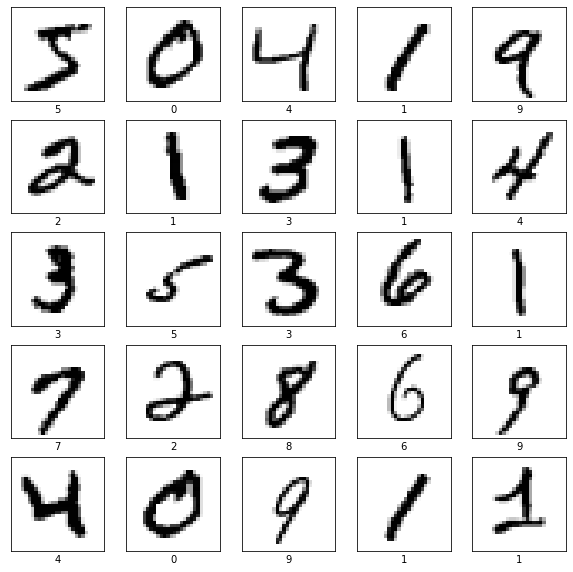

In [0]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [0]:
p = np.array([[0,1,2,3], [4,5,6,7]])
t = 0
np.eye(p.shape[1])[t]

array([1., 0., 0., 0.])

In [0]:
p.shape[1]

4

Test

In [0]:
Xtrain=train_images

In [0]:
Xtrain[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [0]:
np.random.seed(0)

df = AutoDiffTensor(np.array(Xtrain[0]), autodiff=True)
y0 = train_labels[0]
target = AutoDiffTensor(np.array([y0]*28), autodiff=True)

         
model = Sequential([Linear(28,28), Relu(), Linear(28,15), Relu(),Linear(15,10)])

criterion = crossEntropy()

optimiztation = SGD(parameters=model.get_parameters(), alpha=0.1)

y_pred = model.forWard(df)

loss = criterion.forWard(y_pred, target)
  
# Learn
loss.backWard(AutoDiffTensor(np.ones_like(loss.data)))
optimiztation.step()
print(y_pred)



NameError: ignored

In [0]:
print(y_train[0])

In [0]:
print(loss)

In [0]:
np.random.seed(0)


df2 = AutoDiffTensor(np.array([1,2,1,2]), autodiff=True)

target = AutoDiffTensor(np.array([0,1,0,1]), autodiff=True)

model = Sequential([Embedding(3,3), Tanh(), Linear(3,4)])
criterion = crossEntropy()

optimiztation = SGD(parameters=model.get_parameters(), alpha=0.1)

for i in range(10):
    
    # Predict
    pred = model.forWard(df2)
    
    # Compare
    loss = criterion.forWard(pred, target)
    
    # Learn
    loss.backWard(AutoDiffTensor(np.ones_like(loss.data)))
    optim.step()
    print(loss)